Будем выгружать данные о друзьях вк с помощью vk API

In [3]:
pip install vk

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import vk
session = vk.Session()
vk_api = vk.API(session)

Создали standalone приложение и с помощью него через URL получили access токен

In [34]:
session = vk.Session(access_token='fa02f6ccaaf246d7a3f24e68f401c0ce6a95784c110a777a324b9aec45b126c82164ec526b66a2f8615be')

In [35]:
vk_api = vk.API(session, v='5.21')
vk_api.users.get(user_id=137241827, fields='online, last_seen')

[{'id': 137241827,
  'first_name': 'Дина',
  'last_name': 'Сайфутдинова',
  'online': 0,
  'last_seen': {'time': 1584810651, 'platform': 7}}]

Получим список друзей "корневого" пользователя

In [36]:
friends_dict = vk_api.friends.get(user_id=137241827, fields='online, last_seen, sex, bdate, city, country, has_mobile, contacts, education, online, relation, last_seen, status, can_write_private_message, can_see_all_posts, can_post')

In [22]:
id_dict = vk_api.friends.get(user_id=137241827)

In [14]:
from time import sleep

In [49]:
friends = []

In [50]:
vk_api = vk.API(session, v='5.21')

Получаем друзей пользователей из списка друзей, полученного выше

In [51]:
for friend_id in id_dict:
    try:
        r = vk_api.friends.get(user_id=friend_id, fields='online, last_seen, sex, bdate, city, country, has_mobile, contacts, education, status, can_write_private_message, can_see_all_posts, can_post')
        friends.extend(r['items'])
    except:
        ('увы')
    sleep(1)

In [35]:
friends =  friends.extend(friends_dict['items']) # добавляем своих друзей

Всего получили 4908 человек

In [37]:
len(friends)

4908


Сформируем датасет, в котором каждому id пользователя будет соответствовать список признаков: first_name (имя), last_name (фамилия), sex (пол) - возможные значения: 1 — женский; 2 — мужской; 0 — пол не указан, bdate (дата рождения) - дата в формате 'дмг', city (город), country (страна) - представляет собой структуру с полями id и title, has_mobile (известен ли номер мобильного телефона пользователя) - возвращаемые значения: 1 — известен, 0 — не известен, can_post (может ли текущий пользователь оставлять записи на стене) - возможные значения: 1 — может; 0 — не может, can_see_all_posts (может ли текущий пользователь видеть чужие записи на стене) - возможные значения: 1 — может; 0 — не может, can_write_private_message (может ли текущий пользователь отправить личное сообщение) - возможные значения: 1 — может; 0 — не может, status (статус), university (идентификатор университета), university_name (название университета), faculty (идентификатор факультета), faculty_name (название факультета), graduation (год окончания), education_form (форма обучения), education_status (академическая степень)

In [27]:
import pandas as pd

In [86]:
df = pd.DataFrame.from_dict(friends)

In [87]:
data = df[df.first_name != "DELETED"].drop(['online', 'last_seen', 'status_audio', 'online_mobile', 'online_app', 'deactivated', 'mobile_phone', 'home_phone', 'lists'], axis=1).copy()

In [88]:
indices = data["id"]

In [89]:
dataset = data.drop("id", axis=1).set_index(indices).fillna(0).copy()

In [90]:
col = list(data) 
for i in col:
    if data[i].dtype == 'object' or data[i].dtype == 'str':
        data[i] = data[i].fillna('')
    else :
        data[i] = data[i].fillna(0)

In [30]:
import re

In [92]:
dataset.to_csv(r'friends_df.csv', index=True, header=True)

In [28]:
data = pd.read_csv('friends_df.csv')

In [31]:
data['city'] = data['city'].apply(lambda x : x.split())
data['city'] = data['city'].apply(lambda x : x[-1])
data['city'] = data['city'].apply(lambda x : re.sub('[^A-Za-z0-9-А-Яа-я]+', '', x))

In [95]:
data['country'] = data['country'].apply(lambda x : x.split())
data['country'] = data['country'].apply(lambda x : x[-1])
data['country'] = data['country'].apply(lambda x : re.sub('[^A-Za-z0-9-А-Яа-я]+', '', x))

In [115]:
data.columns

Index(['id', 'first_name', 'last_name', 'sex', 'bdate', 'city', 'country',
       'has_mobile', 'can_post', 'can_see_all_posts',
       'can_write_private_message', 'status', 'track_code', 'university',
       'university_name', 'faculty', 'faculty_name', 'graduation',
       'education_form', 'education_status'],
      dtype='object')

выкинем дубликаты

In [147]:
data = data.drop_duplicates(subset=["id"])

In [39]:
data.shape

(4908, 20)


Сохраним датасет

In [41]:
data.to_csv(r'friends_df.csv', index=True, header=True)

In [150]:
indices = data["id"]

Создадим списки смежности, где ключами будет id, а по каждому ключу можно будет получить набор друзей:

In [ ]:
cont_list = {}
counter = 0
for friend_id in indices:
    counter += 1
    try:
        r = vk_api.friends.get(user_id=friend_id)
        cont_list[friend_id] = list(set(r["items"]) & set(indices))
    except:
        ('увы')
    if counter % 100 == 0:
        print(counter, ' друзей обработано')
    sleep(1)

In [3]:
import pickle

In [154]:
with open('adj_dict.txt','wb') as cont_dict:
    pickle.dump(cont_list, cont_dict)

In [19]:
with open('adj_dict.txt','rb') as inp:
    cont_dict = pickle.load(inp)

Визуализируем полученные данные с помощью networkx

In [20]:
import requests
import networkx
import time
import collections

In [21]:
g = networkx.Graph(directed=False)
for i in cont_dict:
    g.add_node(i)
    for j in cont_dict[i]:
        if i != j and i in cont_dict.keys() and j in cont_dict.keys():
            g.add_edge(i, j)

In [22]:
g.number_of_edges() # количество ребер

118668

In [25]:
g.number_of_nodes() # количество вершин

4908

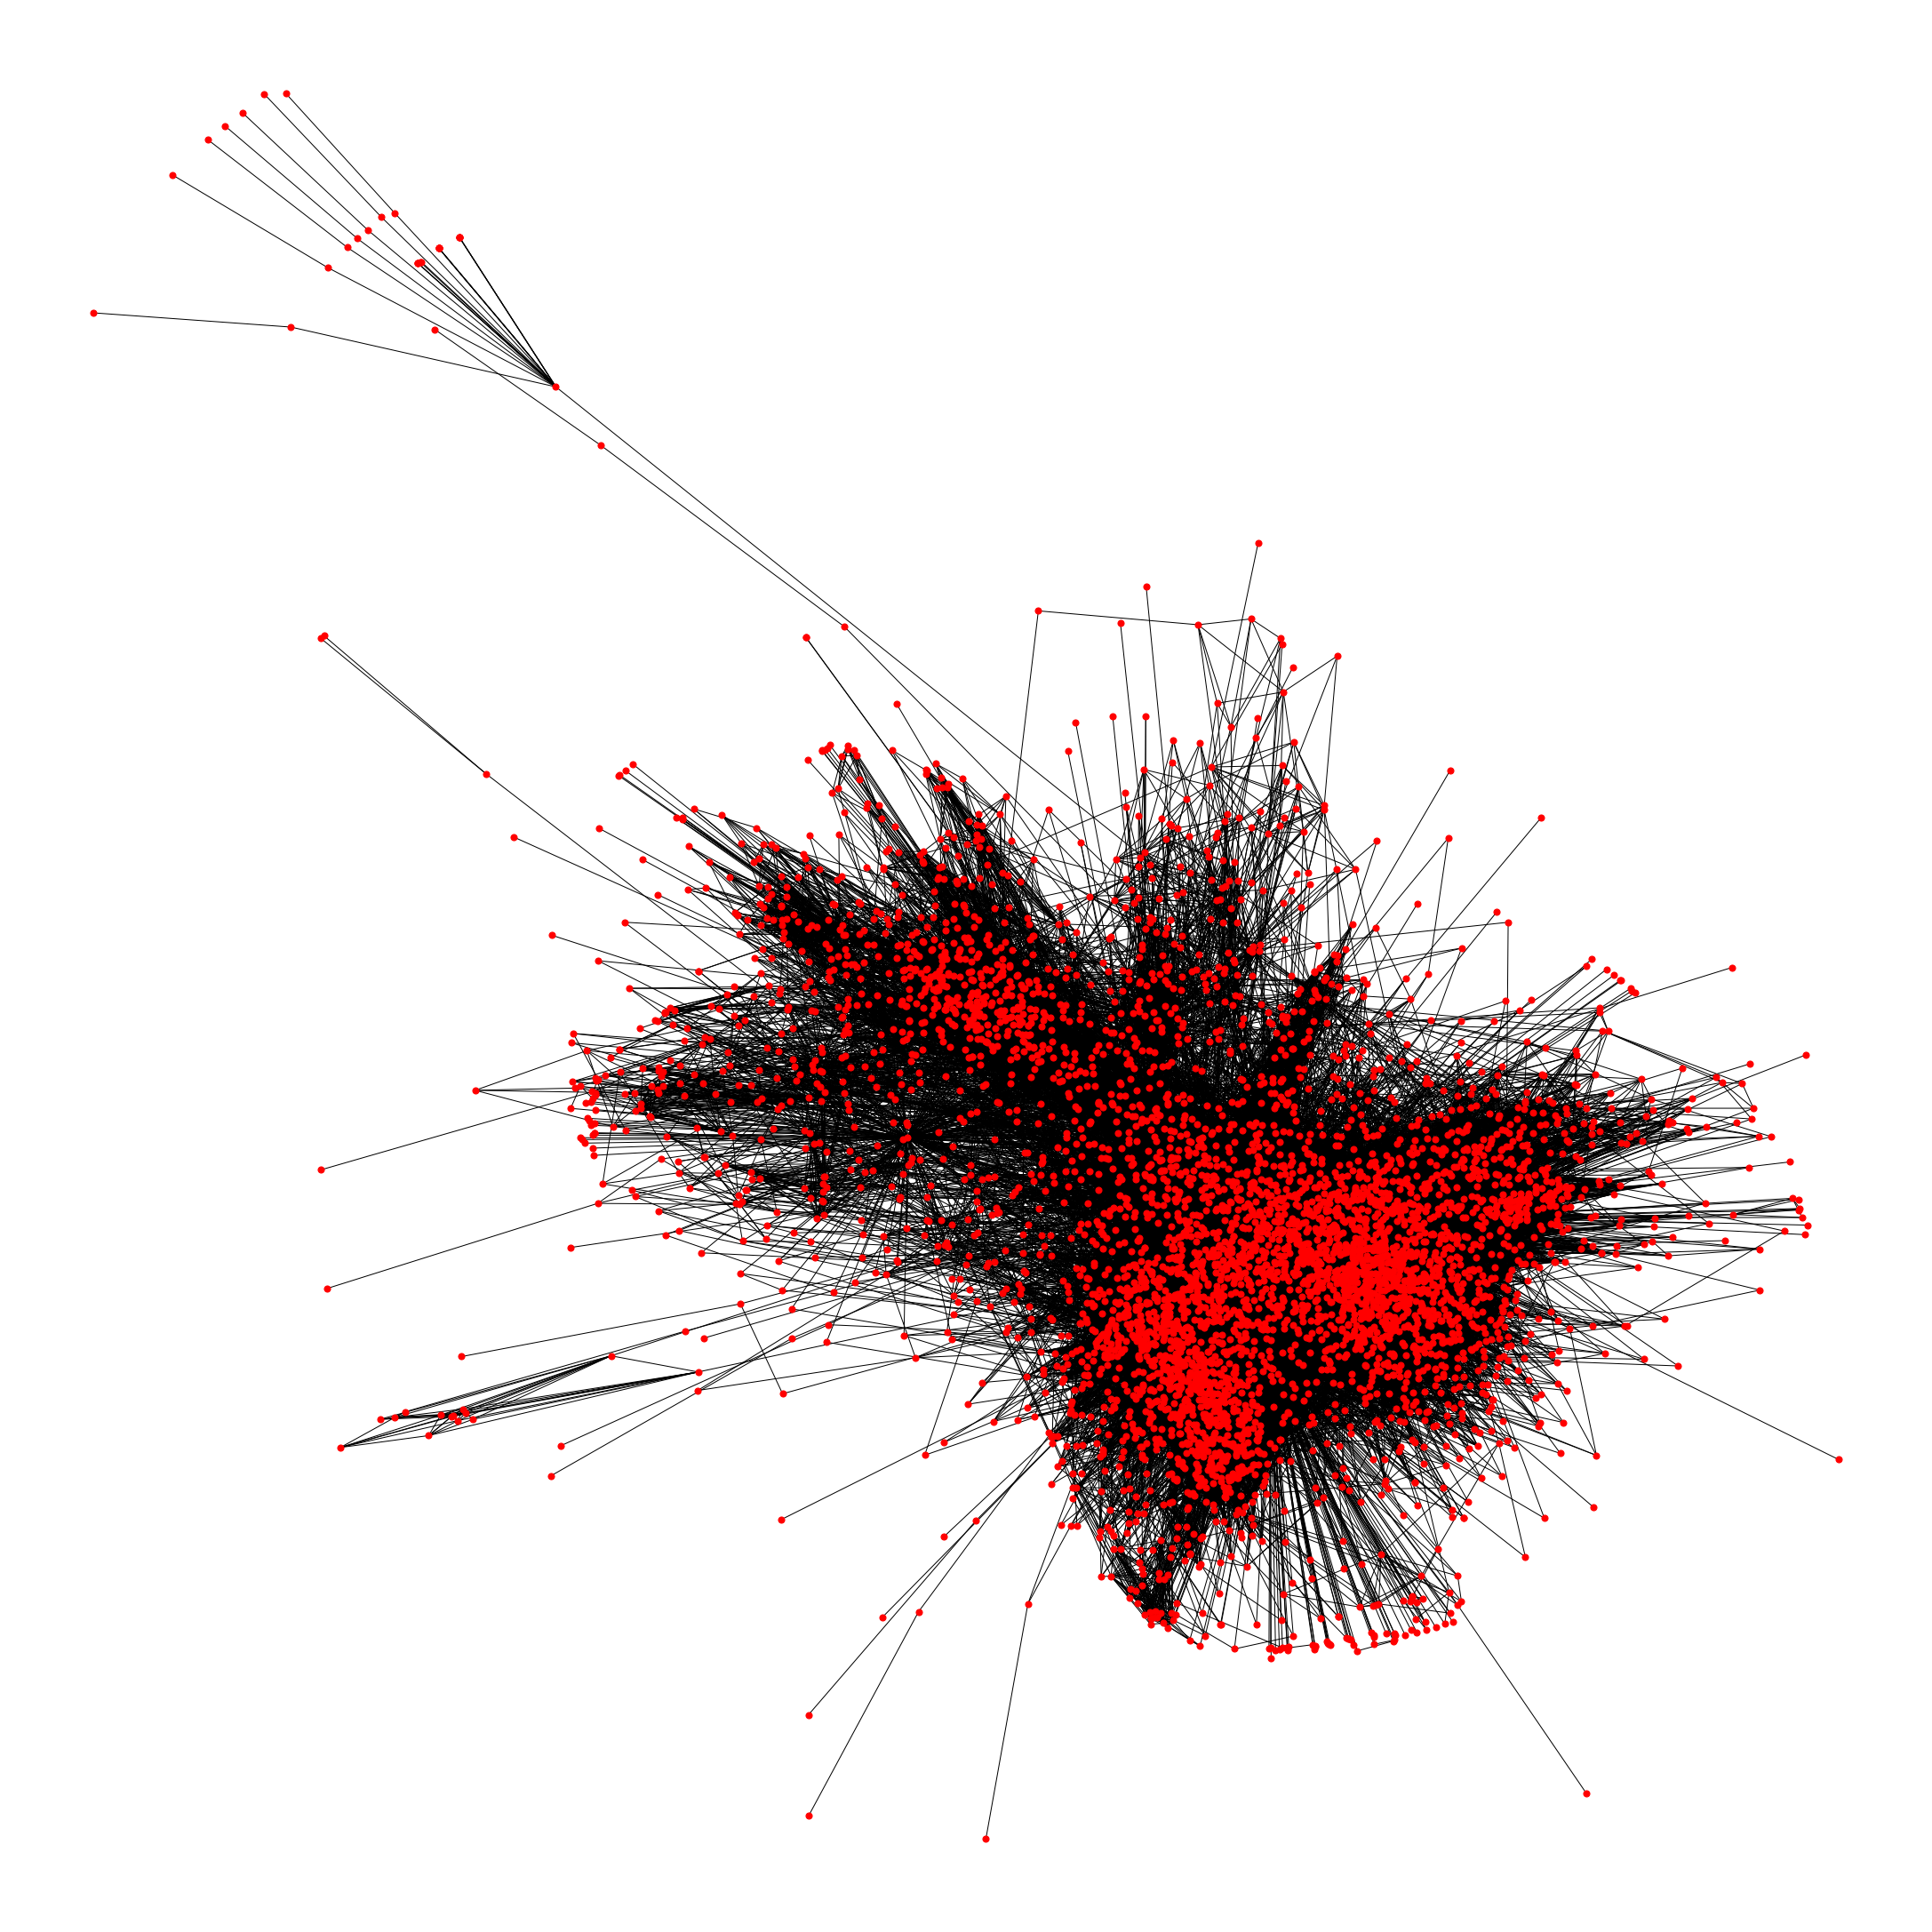

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,  30))
networkx.draw(g, cmap = plt.get_cmap('jet'),node_size=50, node_color = 'r')
plt.show()